In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0,1,2,3,4,5,6,7"
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import AutoModel, AutoTokenizer, pipeline, AutoModelForCausalLM
from swarm.optimizer.edge_optimizer.edge_network import EdgeNetwork
from swarm.optimizer.edge_optimizer.parameterization import EdgeWiseDistributionByModel
import pickle as pkl
import numpy as np
import re

from swarm.graph.swarm import Swarm
from typing import List, Any, Optional

from swarm.llm.custom_llm import CustomLLM
from swarm.llm.format import Message

from vllm import LLM, SamplingParams
import matplotlib.pyplot as plt

from experiments.evaluator.datasets.mmlu_dataset import MMLUDataset
from experiments.evaluator.datasets.cmmlu_dataset import CMMLUDataset
from experiments.evaluator.datasets.mixedmmlu_dataset import MixedMMLUDataset
import pickle
import json
import asyncio
import json
from huggingface_hub import login

/home/lucas/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-06-09 17:33:44,490	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Token has not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /home/lucas/.cache/huggingface/token
Login successful


In [5]:
import pickle
import io

class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cuda:7')
        else:
            return super().find_class(module, name)


In [18]:
path = "mmlu_8true_8adv_noedge_iter200_domain_mmlu_MajorityVote_OptimizedSwarm_1717838293.619214" + ".pkl"
full_path =f"result/mmlu/{path}"
with open(full_path, 'rb') as f:
    #swarm = pickle.load(f)  # Load the swarm
    #score = pickle.load(f)
    #swarm = CPU_Unpickler(f).load()
    #delete swarm object and clear memory
    #score = pickle.load(f)  # Load the score

    pickle_object = pickle.load(f)#{'swarm': swarm, 'score': score}
    score = pickle.load(f)

print(pickle_object)
#print(score)
#print(score)
#print(dict['mean_mmlu'])
#swarm = dict['swarm']
EdgeNetwork.embedding_only = property(lambda self: False)

In [8]:
pickle_object = {"swarm": pickle_object, "score": 48.6}

In [29]:
print(pickle_object["swarm"].connection_dist.model.linear.bias.size())

torch.Size([256])


In [42]:
print(pickle_object)
print(pickle_object['mean_mmlu'])
swarm = pickle_object['swarm']
EdgeNetwork.embedding_only = property(lambda self: False)

TypeError: 'Swarm' object is not subscriptable

In [9]:
swarm = pickle_object['swarm']

In [ ]:

from swarm.graph.swarm import Swarm
from swarm.environment.operations.final_decision import MergingStrategy
from experiments.evaluator.evaluator import Evaluator
from experiments.evaluator.datasets.mmlu_dataset import MMLUDataset
from dataset.MMLU.download import download
from experiments.evaluator.datasets.cmmlu_dataset import CMMLUDataset
from experiments.evaluator.datasets.mixedmmlu_dataset import MixedMMLUDataset
from dataset.CMMLU.download import download as cmmlu_download

from swarm.llm.custom_llm import CustomLLM

swarm = Swarm(
    ["IO"],
    "mmlu",
    model_name="meta-llama/Meta-Llama-3-8B-Instruct",
    final_node_class="FinalDecision",
    final_node_kwargs=dict(strategy=MergingStrategy.MajorityVote),
    edge_optimize=True,
    edge_network_enable=False,
    llm_backbone_name="google/gemma-2B",
)
print(swarm.connection_dist.edge_logits.shape)
#got the swarm, now evaluator
dataset_train = MMLUDataset('dev', categories=["college_mathematics","elementary_mathematics","formal_logic", "abstract_algebra", "high_school_mathematics"])
dataset_val = MMLUDataset('val',categories=["college_mathematics","elementary_mathematics","formal_logic", "abstract_algebra", "high_school_mathematics"])
evaluator = Evaluator(
    swarm,
    dataset_val,
    dataset_val,
    model_name="meta-llama/Meta-Llama-3-8B-Instruct",
    enable_tensorboard = False,
    enable_artifacts=True,
    tensorboard_tag=None)
accs = {}
accs['IO'] = await evaluator.evaluate_agent(agent="IO", limit_questions=25)
accs['COT'] = await evaluator.evaluate_agent(agent="COT", limit_questions=25)


In [ ]:
evaluator = CrosswordsEvaluator(test_data, batch_size=batch_size, metric="words", window_size=num_batches)
swarm = Swarm(["CrosswordsBruteForceOpt","CrosswordsReflection"], "crosswords", "meta-llama/Meta-Llama-3-8B-Instruct",#"google/gemma-7B-it",#,#"gpt-3.5-turbo-1106", #"gpt-4-1106-preview" ,  #"CrosswordsToT","CrosswordsBruteForceOpt","CrosswordsReflection"
            final_node_class="ReturnAll", 
            final_node_kwargs={},
            edge_optimize=True,
            init_connection_probability=init_connection_probability, 
            connect_output_nodes_to_final_node=True, 
            include_inner_agent_connections=True,
            edge_network_enable=edge_network_enable,
            llm_backbone_name=llm_backbone_name)

In [3]:
swarm = pickle_object

In [4]:
def _print_conns(edge_probs: torch.Tensor, swarm):
    assert swarm is not None
    msgs = []
    for i_conn, (conn, prob) in enumerate(zip(
            swarm.connection_dist.potential_connections, edge_probs)):
        src_id, dst_id = conn
        src_node = swarm.composite_graph.find_node(src_id)
        dst_node = swarm.composite_graph.find_node(dst_id)
        src_node_name =  src_node.model_name if hasattr(src_node,"model_name") else src_node.node_name
        dst_node_name = dst_node.model_name if hasattr(dst_node,"model_name") else dst_node.node_name#
        msg = (f"{i_conn}: src={src_node_name}({src_node.id}), "
                f"dst={dst_node_name}({dst_node.id}), prob={prob.item():.3f}")
        msgs.append(msg+"\n")
        print(msg)

def create_adjacency_matrix(edge_probs, swarm):
    assert swarm is not None

    # Create an empty adjacency matrix
    num_nodes = len(swarm.composite_graph.nodes)
    adjacency_matrix = np.zeros((num_nodes, num_nodes))

    # Create a dictionary to map indices to nodes
    node_indices = {}
    node_names = {}
    for index, (node_id, node_ref) in enumerate(swarm.composite_graph.nodes.items()):
        node_indices[node_id] = index
        node_names[node_id] = node_ref.node_name

    # Iterate over the connections and probabilities
    for conn, prob in zip(swarm.connection_dist.potential_connections, edge_probs):
        src_id, dst_id = conn
        src_index = node_indices[src_id]
        dst_index = node_indices[dst_id]
        adjacency_matrix[src_index, dst_index] = prob.item()

    return adjacency_matrix, node_indices, node_names


In [5]:
_print_conns(pickle_object["mean_mmlu"])

TypeError: 'Swarm' object is not subscriptable

In [10]:
import pandas as pd
import copy
import torch

dataset_val = MMLUDataset('test')
print("Total df length:", len(dataset_val._total_df))
#dataset_val._total_df = dataset_val._total_df[:3000]
all_probs = []
swarm.connection_dist.model.eval()

# Initialize list to store all edge_probs
all_edge_probs = []
swarm.connection_dist.model.eval()

for i, record in enumerate(dataset_val):
    record = pd.DataFrame([record])
    input_dict = dataset_val.record_to_swarm_input(record)

    with torch.no_grad():
        edge_probs = swarm.connection_dist.get_edge_probs(swarm.composite_graph, inputs=input_dict)
    
    # Move edge_probs to CPU memory
    edge_probs = edge_probs.cpu()
    
    all_edge_probs.append(edge_probs)


# Stack all edge_probs into a tensor
all_edge_probs = torch.stack(all_edge_probs)

# Calculate mean edge_probs
mean_edge_probs = torch.mean(all_edge_probs, dim=0)
'''
# Initialize list to store distances and corresponding records
distances = []

for record in dataset_val:
    record_copy = copy.deepcopy(record)
    record_df = pd.DataFrame([record_copy])
    input_dict = dataset_val.record_to_swarm_input(record_df)
    edge_probs = swarm.connection_dist.get_edge_probs(swarm.composite_graph, inputs=input_dict)
    
    # Calculate distance to the mean
    distance = torch.norm(edge_probs - mean_edge_probs)
    
    # Store distance and record
    distances.append((distance, record_copy, edge_probs))
# Sort distances in descending order and keep top 10
top_10_records = sorted(distances, key=lambda x: x[0], reverse=True)[:10]

# Extract records from tuples
top_10_records = [(record, edge_probs) for _, record, edge_probs  in top_10_records]
print("top10:")
for record,probs in top_10_records:
    print("Question: ", record)
    _print_conns(probs, swarm)
    print("Subtracting the mean: ")
    _print_conns(mean_edge_probs-probs ,swarm)
    print("----NExt-----")
    '''

Number of topics:  57
Total number of questions:  14042
Total df length: 14042


'\n# Initialize list to store distances and corresponding records\ndistances = []\n\nfor record in dataset_val:\n    record_copy = copy.deepcopy(record)\n    record_df = pd.DataFrame([record_copy])\n    input_dict = dataset_val.record_to_swarm_input(record_df)\n    edge_probs = swarm.connection_dist.get_edge_probs(swarm.composite_graph, inputs=input_dict)\n    \n    # Calculate distance to the mean\n    distance = torch.norm(edge_probs - mean_edge_probs)\n    \n    # Store distance and record\n    distances.append((distance, record_copy, edge_probs))\n# Sort distances in descending order and keep top 10\ntop_10_records = sorted(distances, key=lambda x: x[0], reverse=True)[:10]\n\n# Extract records from tuples\ntop_10_records = [(record, edge_probs) for _, record, edge_probs  in top_10_records]\nprint("top10:")\nfor record,probs in top_10_records:\n    print("Question: ", record)\n    _print_conns(probs, swarm)\n    print("Subtracting the mean: ")\n    _print_conns(mean_edge_probs-probs

In [28]:

from experiments.evaluator.evaluator import Evaluator
evaluator = Evaluator(
        swarm,
        None,
        dataset_val,
        model_name="google/gemma-7B-it",
        enable_tensorboard = False,
        enable_artifacts=True,
        tensorboard_tag=None)


In [ ]:
for record,probs in top_10_records:
    print("Question: ", record)
    _print_conns(probs, swarm)
    print("Subtracting the mean: ")
    _print_conns(mean_edge_probs-probs ,swarm)
    print("----NExt-----")

In [11]:
print(all_edge_probs[:][0])
all_probs_variance = torch.std(all_edge_probs, dim=0)
print(all_probs_variance)
all_probs_mean = torch.mean(all_edge_probs, dim=0)
print(all_probs_variance.shape)
print(all_probs_mean.shape)
print("Mean: ")
_print_conns(all_probs_mean, swarm)
print("Variance: ")
_print_conns(all_probs_variance, swarm)

tensor([3.5272e-01, 9.8385e-01, 9.4760e-01, 5.4164e-01, 7.0452e-01, 8.3598e-02,
        4.0854e-01, 9.9739e-01, 9.0075e-01, 9.7548e-01, 8.7476e-01, 5.3172e-01,
        8.0973e-01, 1.2666e-01, 6.3054e-01, 7.4922e-02, 1.3945e-02, 9.0554e-01,
        1.8023e-01, 6.1842e-01, 9.7970e-01, 5.3265e-01, 8.8791e-01, 1.3858e-01,
        8.3111e-02, 5.1619e-02, 9.8106e-01, 1.7077e-01, 7.0582e-02, 1.1336e-02,
        3.3987e-01, 9.0763e-01, 4.5762e-01, 9.1401e-01, 7.5664e-01, 1.7927e-01,
        1.1560e-01, 3.6790e-02, 5.6086e-01, 9.2085e-01, 1.1294e-01, 8.7303e-01,
        6.6243e-01, 2.7150e-01, 8.7451e-01, 9.9370e-01, 7.7198e-02, 7.1090e-01,
        1.1008e-01, 1.5800e-02, 8.5533e-01, 4.5499e-02, 7.3320e-01, 9.9445e-01,
        4.3934e-02, 7.0029e-02, 5.4057e-01, 9.9804e-01, 1.7169e-01, 3.5371e-02,
        2.4007e-02, 7.2638e-01, 3.3676e-01, 9.5841e-01, 8.8429e-01, 2.0057e-01,
        3.7930e-01, 9.5832e-01, 9.9247e-01, 7.4788e-01, 1.0788e-01, 9.6722e-01,
        3.0674e-01, 9.0242e-01, 7.9670e-

In [20]:
_print_conns(torch.sigmoid(pickle_object.connection_dist.edge_logits),pickle_object)

0: src=google/gemma-7B-it(89DS), dst=google/gemma-7B-it(7hAf), prob=0.448
1: src=google/gemma-7B-it(89DS), dst=google/gemma-7B-it(3kR7), prob=0.088
2: src=google/gemma-7B-it(89DS), dst=google/gemma-7B-it(7H3F), prob=0.144
3: src=google/gemma-7B-it(89DS), dst=google/gemma-7B-it(7Nhv), prob=0.044
4: src=google/gemma-7B-it(89DS), dst=google/gemma-7B-it(4hiS), prob=0.637
5: src=google/gemma-7B-it(89DS), dst=google/gemma-7B-it(xgex), prob=0.168
6: src=google/gemma-7B-it(89DS), dst=google/gemma-7B-it(5ctW), prob=0.802
7: src=google/gemma-7B-it(89DS), dst=AdversarialAnswer(4PKV), prob=0.273
8: src=google/gemma-7B-it(89DS), dst=AdversarialAnswer(3oJi), prob=0.864
9: src=google/gemma-7B-it(89DS), dst=AdversarialAnswer(6aHB), prob=0.835
10: src=google/gemma-7B-it(89DS), dst=AdversarialAnswer(6eGq), prob=0.562
11: src=google/gemma-7B-it(89DS), dst=AdversarialAnswer(7YzH), prob=0.254
12: src=google/gemma-7B-it(89DS), dst=AdversarialAnswer(6DAD), prob=0.831
13: src=google/gemma-7B-it(89DS), dst=Adv

In [21]:
# Initialize the sums of probabilities for Google and Adversarial
sum_google = 0
sum_adversarial = 0

# Provided data
data = [
    "240: src=google/gemma-7B-it(89DS), dst=FinalDecision(648N), prob=0.504",
    "241: src=google/gemma-7B-it(7hAf), dst=FinalDecision(648N), prob=0.812",
    "242: src=google/gemma-7B-it(3kR7), dst=FinalDecision(648N), prob=0.842",
    "243: src=google/gemma-7B-it(7H3F), dst=FinalDecision(648N), prob=0.509",
    "244: src=google/gemma-7B-it(7Nhv), dst=FinalDecision(648N), prob=0.964",
    "245: src=google/gemma-7B-it(4hiS), dst=FinalDecision(648N), prob=0.798",
    "246: src=google/gemma-7B-it(xgex), dst=FinalDecision(648N), prob=0.348",
    "247: src=google/gemma-7B-it(5ctW), dst=FinalDecision(648N), prob=0.141",
    "248: src=AdversarialAnswer(4PKV), dst=FinalDecision(648N), prob=0.760",
    "249: src=AdversarialAnswer(3oJi), dst=FinalDecision(648N), prob=0.062",
    "250: src=AdversarialAnswer(6aHB), dst=FinalDecision(648N), prob=0.910",
    "251: src=AdversarialAnswer(6eGq), dst=FinalDecision(648N), prob=0.133",
    "252: src=AdversarialAnswer(7YzH), dst=FinalDecision(648N), prob=0.470",
    "253: src=AdversarialAnswer(6DAD), dst=FinalDecision(648N), prob=0.395",
    "254: src=AdversarialAnswer(8hhh), dst=FinalDecision(648N), prob=0.289",
    "255: src=AdversarialAnswer(4QaD), dst=FinalDecision(648N), prob=0.209"
]

# Process each line and sum the probabilities based on source
for line in data:
    prob = float(line.split("prob=")[1])
    if "google" in line:
        sum_google += prob
    elif "AdversarialAnswer" in line:
        sum_adversarial += prob

# Print the sums of probabilities for each category
print("Sum of probabilities (Google):", sum_google)
print("Sum of probabilities (Adversarial):", sum_adversarial)


Sum of probabilities (Google): 4.918
Sum of probabilities (Adversarial): 3.228


In [24]:
edge_probs = pickle_object['mean_mmlu']  # Assuming all_probs_mean is defined.
swarm = pickle_object['swarm']

In [5]:
#edge_probs = torch.sigmoid(pickle_object.connection_dist.edge_logits)
edge_probs = torch.sigmoid(swarm.connection_dist.edge_logits)

Mean: 
0: src=DirectAnswer(5Q3h), dst=CoTStep(6RLA), prob=0.997
1: src=DirectAnswer(5Q3h), dst=CoTStep(6Y3D), prob=0.001
2: src=DirectAnswer(5Q3h), dst=CoTStep(8y3C), prob=0.646
3: src=CoTStep(6RLA), dst=DirectAnswer(5Q3h), prob=0.001
4: src=CoTStep(6Y3D), dst=DirectAnswer(5Q3h), prob=0.001
5: src=CoTStep(8y3C), dst=DirectAnswer(5Q3h), prob=0.000
6: src=DirectAnswer(5Q3h), dst=FinalDecision(7fFJ), prob=0.988
7: src=CoTStep(6RLA), dst=FinalDecision(7fFJ), prob=0.169
8: src=CoTStep(6Y3D), dst=FinalDecision(7fFJ), prob=0.004
9: src=CoTStep(8y3C), dst=FinalDecision(7fFJ), prob=0.918
Variance: 
0: src=DirectAnswer(5Q3h), dst=CoTStep(6RLA), prob=0.000
1: src=DirectAnswer(5Q3h), dst=CoTStep(6Y3D), prob=0.000
2: src=DirectAnswer(5Q3h), dst=CoTStep(8y3C), prob=0.000
3: src=CoTStep(6RLA), dst=DirectAnswer(5Q3h), prob=0.000
4: src=CoTStep(6Y3D), dst=DirectAnswer(5Q3h), prob=0.000
5: src=CoTStep(8y3C), dst=DirectAnswer(5Q3h), prob=0.000
6: src=DirectAnswer(5Q3h), dst=FinalDecision(7fFJ), prob=0.000
7: src=CoTStep(6RLA), dst=FinalDecision(7fFJ), prob=0.000
8: src=CoTStep(6Y3D), dst=FinalDecision(7fFJ), prob=0.000
9: src=CoTStep(8y3C), dst=FinalDecision(7fFJ), prob=0.000

0: src=google/gemma-7B-it(GgSb), dst=google/gemma-7B-it(8RYW), prob=0.337
1: src=google/gemma-7B-it(GgSb), dst=google/gemma-7B-it(5JMi), prob=0.982
2: src=google/gemma-7B-it(GgSb), dst=google/gemma-7B-it(8SCz), prob=0.912
3: src=google/gemma-7B-it(GgSb), dst=google/gemma-7B-it(3r6G), prob=0.502
4: src=google/gemma-7B-it(GgSb), dst=google/gemma-7B-it(77mY), prob=0.670
5: src=google/gemma-7B-it(GgSb), dst=google/gemma-7B-it(3Fg7), prob=0.082
6: src=google/gemma-7B-it(GgSb), dst=google/gemma-7B-it(6o5f), prob=0.332
7: src=google/gemma-7B-it(GgSb), dst=AdversarialAnswer(8Ufg), prob=0.997
8: src=google/gemma-7B-it(GgSb), dst=AdversarialAnswer(4oYm), prob=0.895
9: src=google/gemma-7B-it(GgSb), dst=AdversarialAnswer(3Egi), prob=0.970
10: src=google/gemma-7B-it(GgSb), dst=AdversarialAnswer(4qN5), prob=0.873
11: src=google/gemma-7B-it(GgSb), dst=AdversarialAnswer(QhEV), prob=0.540
12: src=google/gemma-7B-it(GgSb), dst=AdversarialAnswer(5qZW), prob=0.735
13: src=google/gemma-7B-it(GgSb), dst=Adv

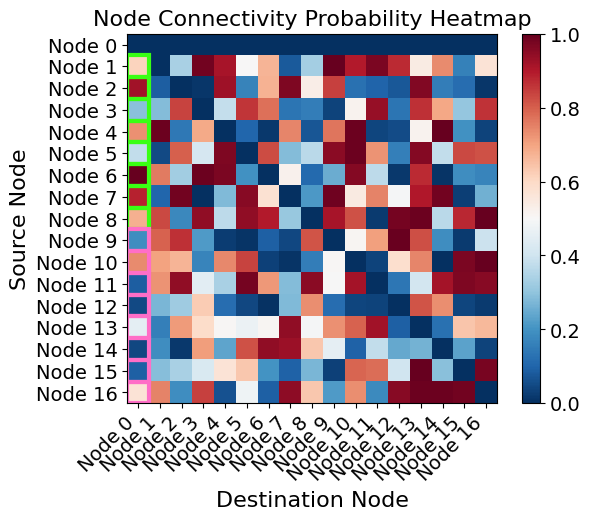

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Assuming create_adjacency_matrix and _print_conns are defined elsewhere.

# Sample data generation (replace this with actual data retrieval)
#edge_probs = torch.sigmoid(swarm.connection_dist.edge_logits)
# _print_conns(edge_probs, swarm)

# Simulating edge probabilities for demonstration:
# Create the adjacency matrix from edge probabilities
# adjacency_matrix, node_indices, names = create_adjacency_matrix(edge_probs, swarm)
# For demonstration, let's use the edge_probs as the adjacency matrix:
adjacency_matrix,node_indices,names = create_adjacency_matrix(edge_probs, swarm)
#reorder the matrix
reorder=False
if reorder:
    print((adjacency_matrix[1::2,:]).shape)
    adjacency_matrix = np.concatenate([adjacency_matrix[0,:][np.newaxis,:], adjacency_matrix[1::2,:], adjacency_matrix[2::2,:]], 0)
    adjacency_matrix = np.concatenate([adjacency_matrix[:,0][:,np.newaxis], adjacency_matrix[:,1::2], adjacency_matrix[:,2::2]], 1)
_print_conns(edge_probs, swarm)
node_indices = {i: i for i in range(17)} #node_indices = {i: i for i in range(9)}
names = {i: f"Node {i}" for i in range(17)} #names = {i: f"Node {i}" for i in range(9)}


# Plotting the heatmap with the reversed 'RdBu' colormap
fig, ax = plt.subplots()
heatmap = ax.imshow(adjacency_matrix, cmap='RdBu_r', vmin=0, vmax=1)  # Note the '_r' to reverse the colormap

# Highlighting two continuous boxed areas
highlighted_indices_1 = [(i, 0) for i in range(1, 9)]  # Rows 1 to 4 and column 1
highlighted_indices_2 = [(i, 0) for i in range(9, 17)]  # Rows 5 to 9 and column 1
for i, j in highlighted_indices_1:
    ax.add_patch(plt.Rectangle((j - 0.5, i - 0.5), 1, 1, fill=None, edgecolor='#39FF14', lw=3))  # Neonish green
for i, j in highlighted_indices_2:
    ax.add_patch(plt.Rectangle((j - 0.5, i - 0.5), 1, 1, fill=None, edgecolor='#FF6EC7', lw=3))  # Neonish pink

# Add a colorbar with increased font size
cbar = plt.colorbar(heatmap)
cbar.ax.tick_params(labelsize=14)  # Increased font size for colorbar tick labels

# Set the tick labels
num_nodes = len(node_indices)
ax.set_xticks(np.arange(num_nodes))
ax.set_yticks(np.arange(num_nodes))
ax.set_xticklabels([names[node_id] for node_id in node_indices], fontsize=14)  # Increased font size for x-axis tick labels
ax.set_yticklabels([names[node_id] for node_id in node_indices], fontsize=14)  # Increased font size for y-axis tick labels

# Rotate the tick labels for better readability
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

# Set the axis labels
ax.set_xlabel('Destination Node', fontsize=16)  # Increased font size for x-axis label
ax.set_ylabel('Source Node', fontsize=16)  # Increased font size for y-axis label

# Set the title
ax.set_title('Node Connectivity Probability Heatmap', fontsize=16)  # Increased font size for title

# Show the plot
plt.show()

In [38]:
print(full_path)

result/mmlu/mmlu_8true_8adv_edge_iter200_domain_mmlu_MajorityVote_OptimizedSwarm_1717744821.4830072.pkl


In [17]:
#dump the edge probs as pickle object
with open(full_path, 'wb') as f:
    pickle_object['mean_mmlu'] = all_probs_mean
    pickle.dump(pickle_object,f)

In [ ]:
adjacency_matrix = np.stack([adjacency_matrix[0::2,:], adjacency_matrix[1::2,:]])
adjacency_matrix = np.stack([adjacency_matrix[:,0::2], adjacency_matrix[:,1::2]])

In [ ]:
adjacency_matrix = np.stack([adjacency_matrix[0::2,:], adjacency_matrix[1::2,:]])
adjacency_matrix = np.stack([adjacency_matrix[:,0::2], adjacency_matrix[:,1::2]])

In [ ]:
adjacency_matrix = np.stack([adjacency_matrix[0::2,:], adjacency_matrix[1::2,:]])
adjacency_matrix = np.stack([adjacency_matrix[:,0::2], adjacency_matrix[:,1::2]])

In [ ]:
print(swarm.connection_dist.model.linear.bias)

In [ ]:
llm = LLM(model="google/gemma-7B-it", dtype="half", max_model_len=5888)

tokenizer = AutoTokenizer.from_pretrained("google/gemma-7B-it")

In [ ]:
message = [{"role": "user", "content": "Write a poem about cats."}]
prompt = tokenizer.apply_chat_template(message, tokenize=False, add_generation_prompt=True)

sampling_params = SamplingParams(temperature=0.8, top_p=0.95, top_k=50,max_tokens=2000)
outputs = llm.generate(prompt,sampling_params=sampling_params)
# Print the outputs.
for output in outputs:
    prompt = output.prompt
    generated_text = output.outputs[0].text
    print(f"Prompt: {prompt!r}, Generated text: {generated_text!r}")

In [ ]:
# pip install accelerate

tokenizer = AutoTokenizer.from_pretrained("google/gemma-7B-it")
#model = AutoModelForCausalLM.from_pretrained("google/gemma-7B-it",torch_dtype=torch.bfloat16).to("cuda")
model = AutoModelForCausalLM.from_pretrained("google/gemma-7B-it", torch_dtype=torch.bfloat16).to("cuda")



In [ ]:
#print(tokenizer.special_tokens_map)
#dummy message
message = [{"role": "user", "content": "Write a poem about cats."}]
prompt = tokenizer.apply_chat_template(message, tokenize=False, add_generation_prompt=True)
prompt = tokenizer.encode(prompt, add_special_tokens=False, return_tensors="pt").to("cuda")
prompt_len = len(prompt[0])
outputs = model.generate(
            prompt,
            do_sample=True,
            max_length=2000,
            top_k=50,
            top_p=1.0
        )
output_text = tokenizer.decode(outputs[0][prompt.shape[-1]:],skip_special_tokens=True)

In [ ]:
print(output_text)

In [ ]:
# Create an instance of the GPTChat class
gpt_chat = CustomLLM()
#gpt_chat_2 = CustomLLM()

In [ ]:

#if gpt_chat is gpt_chat_2:
#    print("Same instance")
# Create a list of Message objects
messages = [Message(role="user", content="What would a dog say if he could speak?")]
# Move messages to GPU
# Create tasks for the gen method
tasks = [asyncio.create_task(gpt_chat.agen(messages))]#, asyncio.create_task(gpt_chat_2.agen(messages))]

# Wait for the tasks to complete and get the results
results = [await task for task in tasks]

# Print the output
print(results)
#print(results[1])

In [ ]:
potential_connections = [0 for _ in range(188)]
init_connection_probability = 0.1
domain = "crosswords"
llm_backbone_name="gpt2"

In [ ]:
swarm = Swarm(["CrosswordsReflection", "CrosswordsToT", "CrosswordsBruteForceOpt"], "crosswords", "gpt-3.5-turbo-1106", #"gpt-4-1106-preview"
            final_node_class="ReturnAll", 
            final_node_kwargs={},
            edge_optimize=True,
            init_connection_probability=init_connection_probability, 
            connect_output_nodes_to_final_node=connect_output_nodes_to_final_node, 
            include_inner_agent_connections=include_inner_agent_connections,
            edge_network_enable=edge_network_enable,
            llm_backbone_name=llm_backbone_name)

In [ ]:
edge_network = EdgeNetwork(llm_backbone_name=llm_backbone_name, num_edges=len(potential_connections), initial_probability=init_connection_probability)
connection_dist = EdgeWiseDistributionByModel(potential_connections, edge_network, domain)

connection_dist.load_state_dict(torch.load("result/crosswords/experiment_edge_logits_10.pt"))

In [ ]:
# Create an instance of EdgeNetwork
num_edges = 188  # Replace with the number of edges used when saving the model
llm_backbone_name = 'gpt2'  # Replace with the name of the model used when saving the model
model = EdgeNetwork(llm_backbone_name, num_edges)

# Load the state dictionary
state_dict = torch.load('result/crosswords/experiment_edge_logits_10.pt')

# Remove 'model.' prefix from state dictionary keys and exclude 'order_params'
state_dict = {k.replace('model.', ''): v for k, v in state_dict.items() if k != 'model.order_params'}

model.load_state_dict(state_dict)

In [ ]:
# Create an instance of EdgeNetwork
num_edges = 188  # Replace with the number of edges used when saving the model
llm_backbone_name = 'gpt2'  # Replace with the name of the model used when saving the model
model = EdgeNetwork(llm_backbone_name, num_edges)

# Load the state dictionary
state_dict = torch.load('result/crosswords/experiment_edge_logits_10.pt')

# Remove 'model.' prefix from state dictionary keys
state_dict = {k.replace('model.', ''): v for k, v in state_dict.items()}

model.load_state_dict(state_dict)